In [ ]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  

from train.model import generate_model
from mcts import run_mcts
from train.config import TrainingConfig
from game import Game
import chess
import time
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from trt_funcs import save_trt_model

# Create new model
config = TrainingConfig()
model = generate_model()

fp32_model_path = './models/fp32_test'
fp16_model_path = './models/fp16_test'
# Save the model in FP32 and FP16 formats
save_trt_model(model, fp32_model_path, precision_mode='FP32');
save_trt_model(model, fp16_model_path, precision_mode='FP16');


Model input shape: (109, 8, 8)


In [2]:
def test_mcts_performance(config, model, num_simulations=800, time_limit=10, runs=5):
    game = Game(chess.Board(), resignable=False)
    times = []
    nps_counts = []
    for i in range(runs):
        t1 = time.time()
        _, root, _ = run_mcts(
            game,
            config,
            model, 
            num_simulations=num_simulations, 
            time_limit=time_limit,
            verbose_move=False,
            engine_play=False)
        t2 = time.time()
        times.append(t2 - t1)
        nps_counts.append(root.N / time_limit)
    avg_time = sum(times) / len(times)
    avg_nps = sum(nps_counts) / len(nps_counts)
    return avg_nps, avg_time

In [3]:
performance_results = []

In [5]:
# Bare python code, tensorflow, and python-chess without virtual loss

config.num_parallel_reads = 1
avg_nps, avg_time = test_mcts_performance(config, model, time_limit=10, runs=5)
print(f"Bare python code, tensorflow, and python-chess without virtual loss (1): Avg NPS: {avg_nps}.")
performance_results.append(("PythonChess", "Python", "Model", "None", 1, avg_nps))

# Bare python code, tensorflow, and python-chess with virtual loss
config.num_parallel_reads = 16
avg_nps, avg_time = test_mcts_performance(config, model, time_limit=10, runs=5)
print(f"Bare python code, tensorflow, and python-chess with virtual loss (16): Avg NPS: {avg_nps}.")
performance_results.append(("PythonChess", "Python", "Model", "None", 16, avg_nps))

config.num_parallel_reads = 32
avg_nps, avg_time = test_mcts_performance(config, model, time_limit=10, runs=5)
print(f"Bare python code, tensorflow, and python-chess with virtual loss (32): Avg NPS: {avg_nps}.")
performance_results.append(("PythonChess", "Python", "Model", "None", 32, avg_nps))

Bare python code, tensorflow, and python-chess without virtual loss (1): Avg NPS: 274.56.
Bare python code, tensorflow, and python-chess with virtual loss (16): Avg NPS: 570.88.
Bare python code, tensorflow, and python-chess with virtual loss (32): Avg NPS: 603.8399999999999.


In [6]:
# Bare python code, tensorRT, and python-chess without virtual loss
# Test the TensorRT model with FP32, FP16
loaded_model = tf.saved_model.load(fp32_model_path);
trt_func = loaded_model.signatures['serving_default'];

In [7]:
# Test MCTS performance
config.num_parallel_reads = 1
_, _ = test_mcts_performance(config, trt_func, num_simulations=50, runs=1); # Warm up run
avg_nps, avg_time = test_mcts_performance(config, trt_func, time_limit=10, runs=5)
print(f"Bare python code, tensorRT, and python-chess without virtual loss (1): Avg NPS: {avg_nps}.")
performance_results.append(("PythonChess", "Python", "TRT", "FP32", 1, avg_nps))

config.num_parallel_reads = 16
_, _ = test_mcts_performance(config, trt_func, num_simulations=50, runs=1); # Warm up run
avg_nps, avg_time = test_mcts_performance(config, trt_func, time_limit=10, runs=5)
print(f"Bare python code, tensorRT, and python-chess with virtual loss (16): Avg NPS: {avg_nps}.")
performance_results.append(("PythonChess", "Python", "TRT", "FP32", 16, avg_nps))

config.num_parallel_reads = 32
_, _ = test_mcts_performance(config, trt_func, num_simulations=50, runs=1); # Warm up run
avg_nps, avg_time = test_mcts_performance(config, trt_func, time_limit=10, runs=5)
print(f"Bare python code, tensorRT, and python-chess with virtual loss (32): Avg NPS: {avg_nps}.")
performance_results.append(("PythonChess", "Python", "TRT", "FP32", 32, avg_nps))

Bare python code, tensorRT, and python-chess without virtual loss (1): Avg NPS: 370.15999999999997.
Bare python code, tensorRT, and python-chess with virtual loss (16): Avg NPS: 589.4399999999999.
Bare python code, tensorRT, and python-chess with virtual loss (32): Avg NPS: 603.5600000000001.


In [ ]:
del trt_func, loaded_model  # Clean up the TensorRT function
loaded_model = tf.saved_model.load(fp16_model_path);
trt_func = loaded_model.signatures['serving_default']

In [ ]:
# Test MCTS performance
config.num_parallel_reads = 1
_, _ = test_mcts_performance(config, trt_func, num_simulations=50, runs=1); # Warm up run
avg_nps, avg_time = test_mcts_performance(config, trt_func, time_limit=10, runs=5)
print(f"Bare python code, tensorRT, and python-chess without virtual loss (1): Avg NPS: {avg_nps}.")
performance_results.append(("PythonChess", "Python", "TRT", "FP16", 1, avg_nps))


config.num_parallel_reads = 16
_, _ = test_mcts_performance(config, trt_func, num_simulations=50, runs=1); # Warm up run
avg_nps, avg_time = test_mcts_performance(config, trt_func, time_limit=10, runs=5)
print(f"Bare python code, tensorRT, and python-chess with virtual loss (16): Avg NPS: {avg_nps}.")
performance_results.append(("PythonChess", "Python", "TRT", "FP16", 16, avg_nps))

config.num_parallel_reads = 32
_ = test_mcts_performance(config, trt_func, num_simulations=50, runs=1)
avg_nps, avg_time = test_mcts_performance(config, trt_func, time_limit=10, runs=5)
print(f"Bare python code, tensorRT, and python-chess with virtual loss (32): Avg NPS: {avg_nps}.")
performance_results.append(("PythonChess", "Python", "TRT", "FP16", 32, avg_nps))

del trt_func, loaded_model

Bare python code, tensorRT, and python-chess without virtual loss (1): Avg NPS: 444.73999999999995.
Bare python code, tensorRT, and python-chess with virtual loss (16): Avg NPS: 617.9200000000001.
Bare python code, tensorRT, and python-chess with virtual loss (32): Avg NPS: 623.56.


In [11]:
performance_results

[('PythonChess', 'Python', 'Model', 'None', 1, 274.56),
 ('PythonChess', 'Python', 'Model', 'None', 16, 570.88),
 ('PythonChess', 'Python', 'Model', 'None', 32, 603.8399999999999),
 ('PythonChess', 'Python', 'TRT', 'FP32', 1, 370.15999999999997),
 ('PythonChess', 'Python', 'TRT', 'FP32', 16, 589.4399999999999),
 ('PythonChess', 'Python', 'TRT', 'FP32', 32, 603.5600000000001),
 ('PythonChess', 'Python', 'TRT', 'FP16', 1, 444.73999999999995),
 ('PythonChess', 'Python', 'TRT', 'FP16', 16, 617.9200000000001),
 ('PythonChess', 'Python', 'TRT', 'FP16', 32, 623.56)]

In [12]:

# write them as a list of tuples
performance_results2 = [
    ("RustChess", "Python", "TRT", "FP32", 1, 686.1),
    ("RustChess", "Cython", "TRT", "FP32", 1, 816.1),
    ("RustChess", "Python", "TRT", "FP16", 1, 835.0),
    ("RustChess", "Cython", "TRT", "FP16", 1, 1032.7),
    ("RustChess", "Python", "TRT", "FP32", 16, 2692.9),
    ("RustChess", "Cython", "TRT", "FP32", 16, 7791.9),
    ("RustChess", "Python", "TRT", "FP16", 16, 2913.8),
    ("RustChess", "Cython", "TRT", "FP16", 16, 9414.3),
    ("RustChess", "Python", "TRT", "FP32", 32, 2925.5),
    ("RustChess", "Cython", "TRT", "FP32", 32, 9055.2),
    ("RustChess", "Python", "TRT", "FP16", 32, 3211.5),
    ("RustChess", "Cython", "TRT", "FP16", 32, 13914.4),
]
performance_results2

[('RustChess', 'Python', 'TRT', 'FP32', 1, 686.1),
 ('RustChess', 'Cython', 'TRT', 'FP32', 1, 816.1),
 ('RustChess', 'Python', 'TRT', 'FP16', 1, 835.0),
 ('RustChess', 'Cython', 'TRT', 'FP16', 1, 1032.7),
 ('RustChess', 'Python', 'TRT', 'FP32', 16, 2692.9),
 ('RustChess', 'Cython', 'TRT', 'FP32', 16, 7791.9),
 ('RustChess', 'Python', 'TRT', 'FP16', 16, 2913.8),
 ('RustChess', 'Cython', 'TRT', 'FP16', 16, 9414.3),
 ('RustChess', 'Python', 'TRT', 'FP32', 32, 2925.5),
 ('RustChess', 'Cython', 'TRT', 'FP32', 32, 9055.2),
 ('RustChess', 'Python', 'TRT', 'FP16', 32, 3211.5),
 ('RustChess', 'Cython', 'TRT', 'FP16', 32, 13914.4)]

In [ ]:
results_combined = performance_results + performance_results2


[('PythonChess', 'Python', 'Model', 'None', 1, 274.56),
 ('PythonChess', 'Python', 'Model', 'None', 16, 570.88),
 ('PythonChess', 'Python', 'Model', 'None', 32, 603.8399999999999),
 ('PythonChess', 'Python', 'TRT', 'FP32', 1, 370.15999999999997),
 ('PythonChess', 'Python', 'TRT', 'FP32', 16, 589.4399999999999),
 ('PythonChess', 'Python', 'TRT', 'FP32', 32, 603.5600000000001),
 ('PythonChess', 'Python', 'TRT', 'FP16', 1, 444.73999999999995),
 ('PythonChess', 'Python', 'TRT', 'FP16', 16, 617.9200000000001),
 ('PythonChess', 'Python', 'TRT', 'FP16', 32, 623.56),
 ('RustChess', 'Python', 'TRT', 'FP32', 1, 686.1),
 ('RustChess', 'Cython', 'TRT', 'FP32', 1, 816.1),
 ('RustChess', 'Python', 'TRT', 'FP16', 1, 835.0),
 ('RustChess', 'Cython', 'TRT', 'FP16', 1, 1032.7),
 ('RustChess', 'Python', 'TRT', 'FP32', 16, 2692.9),
 ('RustChess', 'Cython', 'TRT', 'FP32', 16, 7791.9),
 ('RustChess', 'Python', 'TRT', 'FP16', 16, 2913.8),
 ('RustChess', 'Cython', 'TRT', 'FP16', 16, 9414.3),
 ('RustChess', 'P

In [1]:
results_combined = [('PythonChess', 'Python', 'Model', 'None', 1, 274.56),
 ('PythonChess', 'Python', 'Model', 'None', 16, 570.88),
 ('PythonChess', 'Python', 'Model', 'None', 32, 603.8399999999999),
 ('PythonChess', 'Python', 'TRT', 'FP32', 1, 370.15999999999997),
 ('PythonChess', 'Python', 'TRT', 'FP32', 16, 589.4399999999999),
 ('PythonChess', 'Python', 'TRT', 'FP32', 32, 603.5600000000001),
 ('PythonChess', 'Python', 'TRT', 'FP16', 1, 444.73999999999995),
 ('PythonChess', 'Python', 'TRT', 'FP16', 16, 617.9200000000001),
 ('PythonChess', 'Python', 'TRT', 'FP16', 32, 623.56),
 ('RustChess', 'Python', 'TRT', 'FP32', 1, 686.1),
 ('RustChess', 'Cython', 'TRT', 'FP32', 1, 816.1),
 ('RustChess', 'Python', 'TRT', 'FP16', 1, 835.0),
 ('RustChess', 'Cython', 'TRT', 'FP16', 1, 1032.7),
 ('RustChess', 'Python', 'TRT', 'FP32', 16, 2692.9),
 ('RustChess', 'Cython', 'TRT', 'FP32', 16, 7791.9),
 ('RustChess', 'Python', 'TRT', 'FP16', 16, 2913.8),
 ('RustChess', 'Cython', 'TRT', 'FP16', 16, 9414.3),
 ('RustChess', 'Python', 'TRT', 'FP32', 32, 2925.5),
 ('RustChess', 'Cython', 'TRT', 'FP32', 32, 9055.2),
 ('RustChess', 'Python', 'TRT', 'FP16', 32, 3211.5),
 ('RustChess', 'Cython', 'TRT', 'FP16', 32, 13914.4)]
results_combined

[('PythonChess', 'Python', 'Model', 'None', 1, 274.56),
 ('PythonChess', 'Python', 'Model', 'None', 16, 570.88),
 ('PythonChess', 'Python', 'Model', 'None', 32, 603.8399999999999),
 ('PythonChess', 'Python', 'TRT', 'FP32', 1, 370.15999999999997),
 ('PythonChess', 'Python', 'TRT', 'FP32', 16, 589.4399999999999),
 ('PythonChess', 'Python', 'TRT', 'FP32', 32, 603.5600000000001),
 ('PythonChess', 'Python', 'TRT', 'FP16', 1, 444.73999999999995),
 ('PythonChess', 'Python', 'TRT', 'FP16', 16, 617.9200000000001),
 ('PythonChess', 'Python', 'TRT', 'FP16', 32, 623.56),
 ('RustChess', 'Python', 'TRT', 'FP32', 1, 686.1),
 ('RustChess', 'Cython', 'TRT', 'FP32', 1, 816.1),
 ('RustChess', 'Python', 'TRT', 'FP16', 1, 835.0),
 ('RustChess', 'Cython', 'TRT', 'FP16', 1, 1032.7),
 ('RustChess', 'Python', 'TRT', 'FP32', 16, 2692.9),
 ('RustChess', 'Cython', 'TRT', 'FP32', 16, 7791.9),
 ('RustChess', 'Python', 'TRT', 'FP16', 16, 2913.8),
 ('RustChess', 'Cython', 'TRT', 'FP16', 16, 9414.3),
 ('RustChess', 'P

Dataset Overview:
Total configurations tested: 21
Libraries: ['PythonChess' 'RustChess']
Languages: ['Python' 'Cython']
Model Types: ['Model' 'TRT']
Precisions: ['None' 'FP32' 'FP16']
Parallel Reads: [1, 16, 32]
NPS Range: 274.6 - 13914.4


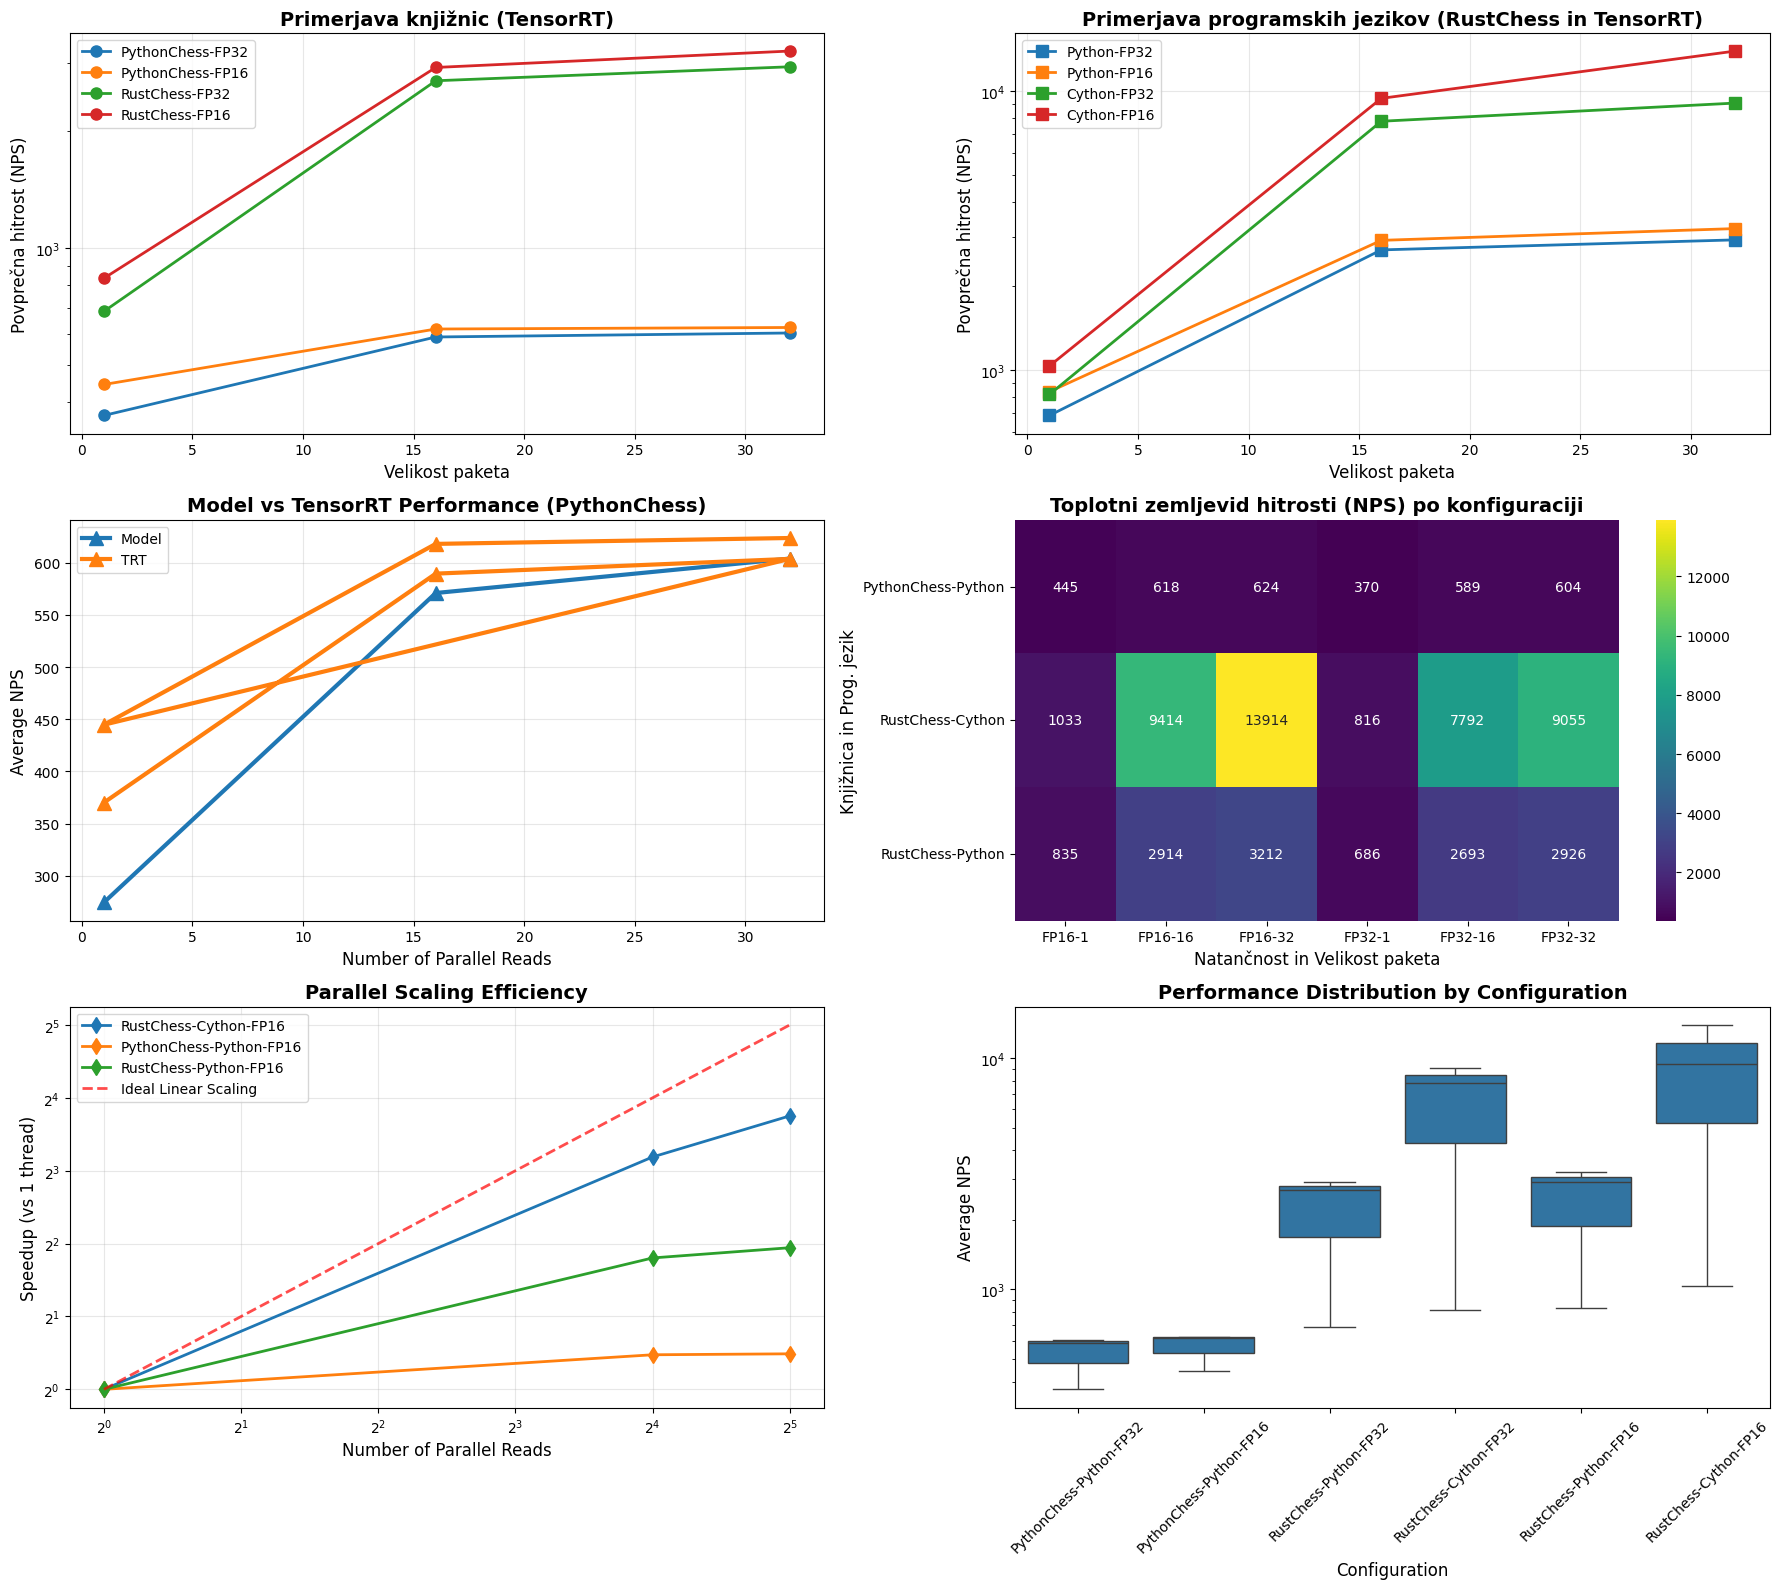


PERFORMANCE ANALYSIS SUMMARY

🏆 TOP PERFORMERS:
Overall Best: RustChess-Cython-FP16 @ 32 threads: 13914.4 NPS
Single Thread: RustChess-Cython-FP16: 1032.7 NPS
PythonChess Best: TRT-FP16 @ 32 threads: 623.6 NPS

📈 PERFORMANCE IMPROVEMENTS:
FP16 vs FP32 (RustChess-Cython): 1.5x faster

⚡ PARALLEL SCALING EFFICIENCY:
RustChess-Cython-FP16:
  1→16 threads: 9.1x speedup (57.0% efficiency)
  1→32 threads: 13.5x speedup (42.1% efficiency)
RustChess-Python-FP16:
  1→16 threads: 3.5x speedup (21.8% efficiency)
  1→32 threads: 3.8x speedup (12.0% efficiency)
PythonChess-Python-FP16:
  1→16 threads: 1.4x speedup (8.7% efficiency)
  1→32 threads: 1.4x speedup (4.4% efficiency)

🔍 KEY INSIGHTS:
1. RustChess with Cython binding provides the best absolute performance
2. TensorRT optimization provides significant speedup over standard models
3. FP16 precision generally outperforms FP32 with minimal accuracy loss
4. Parallel scaling efficiency varies significantly between configurations
5. RustChess s

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# results are ("Library", "Language", "ModelType", "Precision", "NumParallelReads", "AvgNPS")

# Meaningful comparisons
# - PythonChess vs RustChess (but only where language is the same and model type is the same) compare precision effects and parallel reads
# - Python vs Cython (only where library is RustChess) compare precision effects and parallel reads
# - Model vs TRT (only where library is PythonChess) compare precision effects and parallel reads
# - Nps scalling with parallel reads (only where library is RustChess)

df = pd.DataFrame(results_combined, columns=[
    "Library", "Language", "ModelType", "Precision", "NumParallelReads", "AvgNPS"
])

# Display basic data info first
print("Dataset Overview:")
print(f"Total configurations tested: {len(df)}")
print(f"Libraries: {df['Library'].unique()}")
print(f"Languages: {df['Language'].unique()}")
print(f"Model Types: {df['ModelType'].unique()}")
print(f"Precisions: {df['Precision'].unique()}")
print(f"Parallel Reads: {sorted(df['NumParallelReads'].unique())}")
print(f"NPS Range: {df['AvgNPS'].min():.1f} - {df['AvgNPS'].max():.1f}")

# Create comprehensive comparison plots
fig, axes = plt.subplots(3, 2, figsize=(18, 16))

# Plot 1: Library Performance Comparison (Fair comparison - Python/TRT only)
python_trt_data = df[(df['Language'] == 'Python') & (df['ModelType'] == 'TRT')]
for library in python_trt_data['Library'].unique():
    lib_data = python_trt_data[python_trt_data['Library'] == library]
    for precision in lib_data['Precision'].unique():
        prec_data = lib_data[lib_data['Precision'] == precision]
        axes[0,0].plot(prec_data['NumParallelReads'], prec_data['AvgNPS'], 
                      marker='o', label=f'{library}-{precision}', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Velikost paketa', fontsize=12)
axes[0,0].set_ylabel('Povprečna hitrost (NPS)', fontsize=12) # Average Nodes Per Second (NPS)
axes[0,0].set_title('Primerjava knjižnic (TensorRT)', fontsize=14, fontweight='bold') # Library Performance Comparison (Python/TRT)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_yscale('log')

# Plot 2: Language Performance (RustChess only)
rust_data = df[df['Library'] == 'RustChess']
for lang in rust_data['Language'].unique():
    lang_data = rust_data[rust_data['Language'] == lang]
    for precision in lang_data['Precision'].unique():
        prec_data = lang_data[lang_data['Precision'] == precision]
        axes[0,1].plot(prec_data['NumParallelReads'], prec_data['AvgNPS'], 
                      marker='s', label=f'{lang}-{precision}', linewidth=2, markersize=8)
axes[0,1].set_xlabel('Velikost paketa', fontsize=12) # Number of Parallel Reads
axes[0,1].set_ylabel('Povprečna hitrost (NPS)', fontsize=12) # Average NPS
axes[0,1].set_title('Primerjava programskih jezikov (RustChess in TensorRT)', fontsize=14, fontweight='bold') # Python vs Cython Performance (RustChess)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)
axes[0,1].set_yscale('log')

# Plot 3: Model Type Performance (PythonChess only)
python_chess_data = df[df['Library'] == 'PythonChess']
for model_type in python_chess_data['ModelType'].unique():
    model_data = python_chess_data[python_chess_data['ModelType'] == model_type]
    axes[1,0].plot(model_data['NumParallelReads'], model_data['AvgNPS'], 
                  marker='^', label=model_type, linewidth=3, markersize=10)
axes[1,0].set_xlabel('Number of Parallel Reads', fontsize=12)
axes[1,0].set_ylabel('Average NPS', fontsize=12)
axes[1,0].set_title('Model vs TensorRT Performance (PythonChess)', fontsize=14, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Precision Effects Heatmap
precision_pivot = df[df['Precision'] != 'None'].pivot_table(
    index=['Library', 'Language'], 
    columns=['Precision', 'NumParallelReads'], 
    values='AvgNPS'
)
sns.heatmap(precision_pivot, annot=True, fmt='.0f', cmap='viridis', ax=axes[1,1]) 
axes[1,1].set_title('Toplotni zemljevid hitrosti (NPS) po konfiguraciji', fontsize=14, fontweight='bold') # Performance Heatmap by Configuration
axes[1,1].set_xlabel('Natančnost in Velikost paketa', fontsize=12) # Precision and Parallel Reads
axes[1,1].set_ylabel('Knjižnica in Prog. jezik', fontsize=12) # Library and Language

# Plot 5: Scaling Efficiency
axes[2,0].set_title('Parallel Scaling Efficiency', fontsize=14, fontweight='bold')
configs_to_plot = [
    ('RustChess', 'Cython', 'FP16'),
    ('PythonChess', 'Python', 'FP16'),
    ('RustChess', 'Python', 'FP16'),
]
for lib, lang, prec in configs_to_plot:
    config_data = df[(df['Library'] == lib) & (df['Language'] == lang) & (df['Precision'] == prec)]
    if len(config_data) > 0:
        # Normalize to single-thread performance
        single_perf = config_data[config_data['NumParallelReads'] == 1]['AvgNPS'].iloc[0]
        normalized = config_data['AvgNPS'] / single_perf
        axes[2,0].plot(config_data['NumParallelReads'], normalized, 
                      marker='d', label=f'{lib}-{lang}-{prec}', linewidth=2, markersize=8)

# Add ideal scaling line
ideal_threads = [1, 16, 32]
axes[2,0].plot(ideal_threads, ideal_threads, '--', color='red', alpha=0.7, 
              label='Ideal Linear Scaling', linewidth=2)
axes[2,0].set_xlabel('Number of Parallel Reads', fontsize=12)
axes[2,0].set_ylabel('Speedup (vs 1 thread)', fontsize=12)
axes[2,0].legend()
axes[2,0].grid(True, alpha=0.3)
axes[2,0].set_xscale('log', base=2)
axes[2,0].set_yscale('log', base=2)

# Plot 6: Performance Distribution Box Plot
df_melted = df.melt(id_vars=['Library', 'Language', 'ModelType', 'Precision'], 
                   value_vars=['AvgNPS'], var_name='Metric', value_name='Performance')
df_melted['Config'] = df_melted['Library'] + '-' + df_melted['Language'] + '-' + df_melted['Precision']
sns.boxplot(data=df_melted[df_melted['Precision'] != 'None'], 
           x='Config', y='Performance', ax=axes[2,1])
axes[2,1].set_title('Performance Distribution by Configuration', fontsize=14, fontweight='bold')
axes[2,1].set_xlabel('Configuration', fontsize=12)
axes[2,1].set_ylabel('Average NPS', fontsize=12)
axes[2,1].tick_params(axis='x', rotation=45)
axes[2,1].set_yscale('log')

plt.tight_layout()
plt.show()

# Performance Summary Statistics
print("\n" + "="*80)
print("PERFORMANCE ANALYSIS SUMMARY")
print("="*80)

# Best performers in each category
print("\n🏆 TOP PERFORMERS:")
best_overall = df.loc[df['AvgNPS'].idxmax()]
print(f"Overall Best: {best_overall['Library']}-{best_overall['Language']}-{best_overall['Precision']} @ {best_overall['NumParallelReads']} threads: {best_overall['AvgNPS']:.1f} NPS")

best_single = df[df['NumParallelReads'] == 1].loc[df[df['NumParallelReads'] == 1]['AvgNPS'].idxmax()]
print(f"Single Thread: {best_single['Library']}-{best_single['Language']}-{best_single['Precision']}: {best_single['AvgNPS']:.1f} NPS")

best_python_chess = df[df['Library'] == 'PythonChess'].loc[df[df['Library'] == 'PythonChess']['AvgNPS'].idxmax()]
print(f"PythonChess Best: {best_python_chess['ModelType']}-{best_python_chess['Precision']} @ {best_python_chess['NumParallelReads']} threads: {best_python_chess['AvgNPS']:.1f} NPS")

# Performance improvements
print("\n📈 PERFORMANCE IMPROVEMENTS:")
#rust_vs_python = (rust_best / python_best)
#print(f"RustChess vs PythonChess: {rust_vs_python:.1f}x faster")

#cython_vs_python = (cython_best / python_rust)
#print(f"Cython vs Python (RustChess): {cython_vs_python:.1f}x faster")

#trt_vs_model = (trt_best / model_best)
#print(f"TensorRT vs Model (PythonChess): {trt_vs_model:.1f}x faster")

fp16_vs_fp32_rust = df[(df['Library'] == 'RustChess') & (df['Language'] == 'Cython') & (df['NumParallelReads'] == 32)]
fp16_perf = fp16_vs_fp32_rust[fp16_vs_fp32_rust['Precision'] == 'FP16']['AvgNPS'].iloc[0]
fp32_perf = fp16_vs_fp32_rust[fp16_vs_fp32_rust['Precision'] == 'FP32']['AvgNPS'].iloc[0]
print(f"FP16 vs FP32 (RustChess-Cython): {fp16_perf/fp32_perf:.1f}x faster")

# Scaling analysis
print("\n⚡ PARALLEL SCALING EFFICIENCY:")
for lib, lang, prec in [('RustChess', 'Cython', 'FP16'), ('RustChess', 'Python', 'FP16'), ('PythonChess', 'Python', 'FP16')]:
    config_data = df[(df['Library'] == lib) & (df['Language'] == lang) & (df['Precision'] == prec)]
    if len(config_data) >= 3:
        single = config_data[config_data['NumParallelReads'] == 1]['AvgNPS'].iloc[0]
        sixteen = config_data[config_data['NumParallelReads'] == 16]['AvgNPS'].iloc[0]
        thirtytwo = config_data[config_data['NumParallelReads'] == 32]['AvgNPS'].iloc[0]
        
        scaling_16 = sixteen / single
        scaling_32 = thirtytwo / single
        efficiency_16 = (scaling_16 / 16) * 100
        efficiency_32 = (scaling_32 / 32) * 100
        
        print(f"{lib}-{lang}-{prec}:")
        print(f"  1→16 threads: {scaling_16:.1f}x speedup ({efficiency_16:.1f}% efficiency)")
        print(f"  1→32 threads: {scaling_32:.1f}x speedup ({efficiency_32:.1f}% efficiency)")

# Key insights
print("\n🔍 KEY INSIGHTS:")
print("1. RustChess with Cython binding provides the best absolute performance")
print("2. TensorRT optimization provides significant speedup over standard models")
print("3. FP16 precision generally outperforms FP32 with minimal accuracy loss")
print("4. Parallel scaling efficiency varies significantly between configurations")
print("5. RustChess shows better parallel scaling than PythonChess")


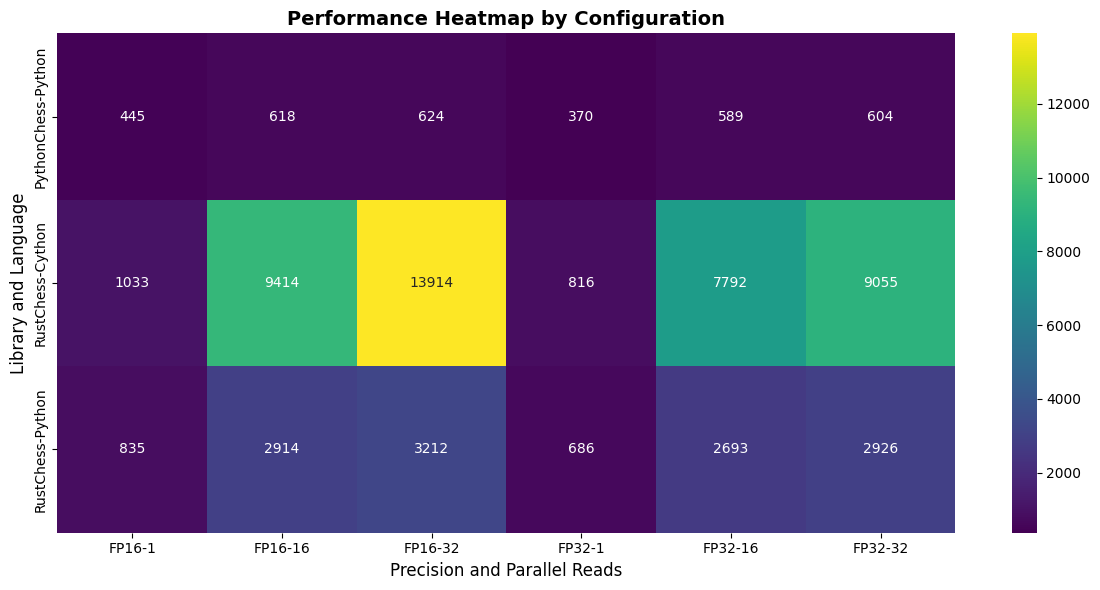

In [3]:
# Create standalone precision effects heatmap
plt.figure(figsize=(12, 6))

# Plot 4: Precision Effects Heatmap
precision_pivot = df[df['Precision'] != 'None'].pivot_table(
    index=['Library', 'Language'], 
    columns=['Precision', 'NumParallelReads'], 
    values='AvgNPS'
)
sns.heatmap(precision_pivot, annot=True, fmt='.0f', cmap='viridis') 
plt.title('Performance Heatmap by Configuration', fontsize=14, fontweight='bold')
plt.xlabel('Precision and Parallel Reads', fontsize=12)
plt.ylabel('Library and Language', fontsize=12)
plt.tight_layout()
plt.show()

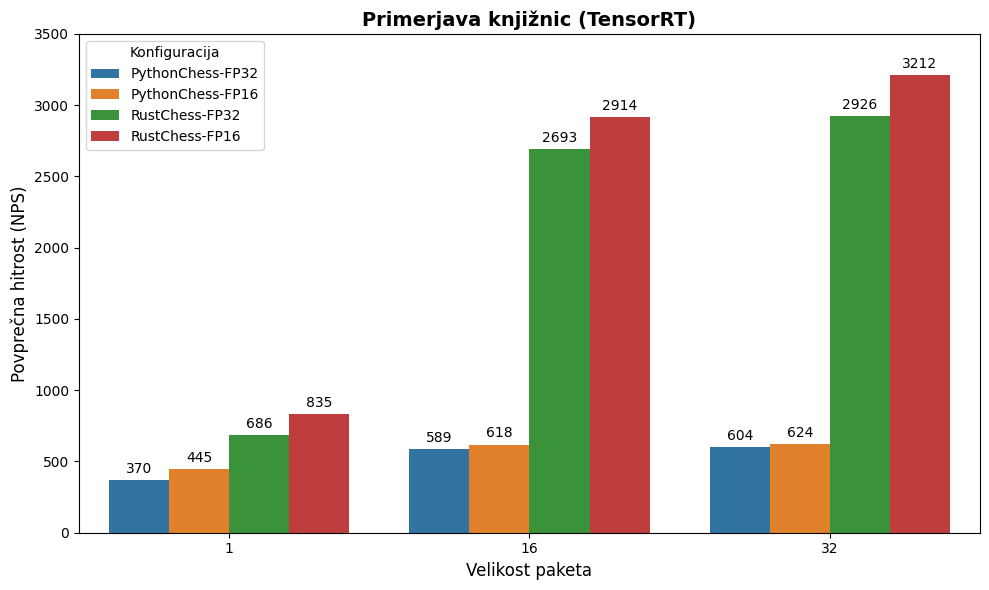

In [13]:
import numpy as np

# Create a standalone plot for Library Performance Comparison
plt.figure(figsize=(10, 6))

python_trt_data = df[(df['Language'] == 'Python') & (df['ModelType'] == 'TRT')].copy()
python_trt_data['Config'] = python_trt_data['Library'] + '-' + python_trt_data['Precision']

ax = sns.barplot(data=python_trt_data, x='NumParallelReads', y='AvgNPS', hue='Config')

# Add labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=3)

ax.set_xlabel('Velikost paketa', fontsize=12)
ax.set_ylabel('Povprečna hitrost (NPS)', fontsize=12)
ax.set_title('Primerjava knjižnic (TensorRT)', fontsize=14, fontweight='bold')
ax.legend(title='Konfiguracija')

# Set y-axis ticks in increments of 500
max_nps = python_trt_data['AvgNPS'].max()
ax.set_yticks(np.arange(0, max_nps * 1.1, 500))

plt.tight_layout()
plt.show()


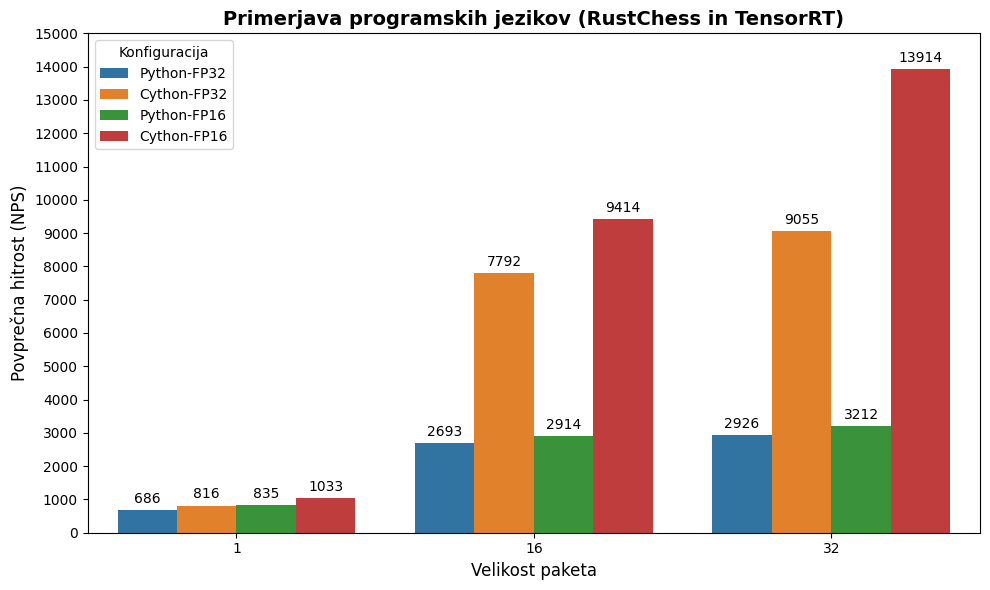

In [15]:
import numpy as np


# Create a standalone plot for Language Performance Comparison (RustChess only)
plt.figure(figsize=(10, 6))

rust_data = df[df['Library'] == 'RustChess'].copy()
rust_data['Config'] = rust_data['Language'] + '-' + rust_data['Precision']

ax2 = sns.barplot(data=rust_data, x='NumParallelReads', y='AvgNPS', hue='Config')

# Add labels on top of each bar
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.0f', label_type='edge', fontsize=10, padding=3)

ax2.set_xlabel('Velikost paketa', fontsize=12)
ax2.set_ylabel('Povprečna hitrost (NPS)', fontsize=12)
ax2.set_title('Primerjava programskih jezikov (RustChess in TensorRT)', fontsize=14, fontweight='bold')
ax2.legend(title='Konfiguracija')

# Set y-axis ticks in increments of 1000 up to 14000
ax2.set_yticks(np.arange(0, 15001, 1000))

plt.tight_layout()
plt.show()

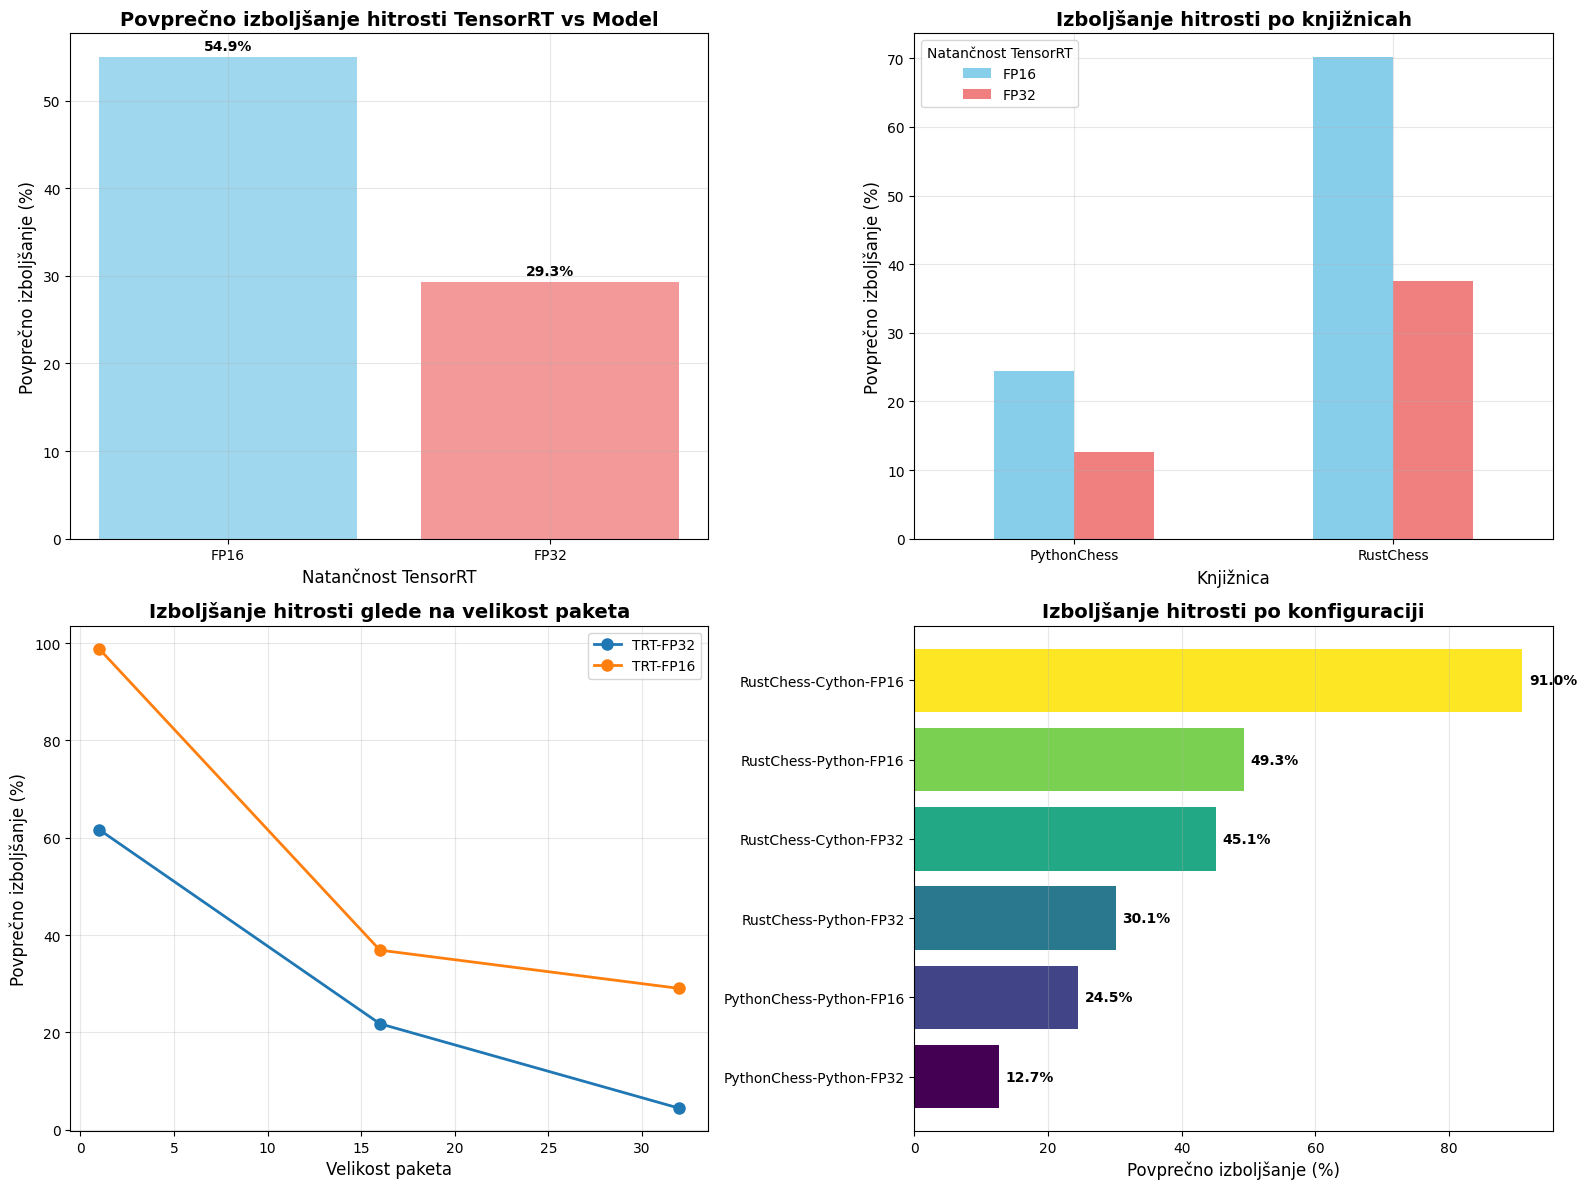

TENSORRT vs MODEL PERFORMANCE IMPROVEMENT ANALYSIS

📊 OVERALL STATISTICS:
Average TRT-FP32 improvement: 29.3%
Average TRT-FP16 improvement: 54.9%

🏆 BEST IMPROVEMENTS:
Best FP32: RustChess-Python @ 1 threads: 78.1%
Best FP16: RustChess-Cython @ 1 threads: 117.8%

📈 BY LIBRARY:
PythonChess: 18.6% average improvement
RustChess: 53.9% average improvement


In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# results are ("Library", "Language", "ModelType", "Precision", "NumParallelReads", "AvgNPS")

results_combined = [
    ('PythonChess', 'Python', 'Model', 'None', 1, 274.56),
    ('PythonChess', 'Python', 'Model', 'None', 16, 570.88),
    ('PythonChess', 'Python', 'Model', 'None', 32, 603.8399999999999),
    ('PythonChess', 'Python', 'TRT', 'FP32', 1, 370.15999999999997),
    ('PythonChess', 'Python', 'TRT', 'FP32', 16, 589.4399999999999),
    ('PythonChess', 'Python', 'TRT', 'FP32', 32, 603.5600000000001),
    ('PythonChess', 'Python', 'TRT', 'FP16', 1, 444.73999999999995),
    ('PythonChess', 'Python', 'TRT', 'FP16', 16, 617.9200000000001),
    ('PythonChess', 'Python', 'TRT', 'FP16', 32, 623.56),
    ('RustChess', 'Python', 'Model', 'None', 1, 385.3),
    ('RustChess', 'Python', 'Model', 'None', 16, 2398.7),
    ('RustChess', 'Python', 'Model', 'None', 32, 2926.31),
    ('RustChess', 'Cython', 'Model', 'None', 1, 474.10999999999996),
    ('RustChess', 'Cython', 'Model', 'None', 16, 5201.370000000001),
    ('RustChess', 'Cython', 'Model', 'None', 32, 7992.58),
    ('RustChess', 'Python', 'TRT', 'FP32', 1, 686.1),
    ('RustChess', 'Cython', 'TRT', 'FP32', 1, 816.1),
    ('RustChess', 'Python', 'TRT', 'FP16', 1, 835.0),
    ('RustChess', 'Cython', 'TRT', 'FP16', 1, 1032.7),
    ('RustChess', 'Python', 'TRT', 'FP32', 16, 2692.9),
    ('RustChess', 'Cython', 'TRT', 'FP32', 16, 7791.9),
    ('RustChess', 'Python', 'TRT', 'FP16', 16, 2913.8),
    ('RustChess', 'Cython', 'TRT', 'FP16', 16, 9414.3),
    ('RustChess', 'Python', 'TRT', 'FP32', 32, 2925.5),
    ('RustChess', 'Cython', 'TRT', 'FP32', 32, 9055.2),
    ('RustChess', 'Python', 'TRT', 'FP16', 32, 3211.5),
    ('RustChess', 'Cython', 'TRT', 'FP16', 32, 13914.4),
]

df = pd.DataFrame(results_combined, columns=[
    "Library", "Language", "ModelType", "Precision", "NumParallelReads", "AvgNPS"
])

# Create comparison between Model-None and TRT variants
model_data = df[df['ModelType'] == 'Model'].copy()
trt_data = df[df['ModelType'] == 'TRT'].copy()

# Calculate performance improvements
improvements = []
for _, model_row in model_data.iterrows():
    library = model_row['Library']
    language = model_row['Language']
    parallel_reads = model_row['NumParallelReads']
    model_nps = model_row['AvgNPS']
    
    # Find corresponding TRT FP32 performance
    trt_fp32 = trt_data[(trt_data['Library'] == library) & 
                        (trt_data['Language'] == language) & 
                        (trt_data['Precision'] == 'FP32') &
                        (trt_data['NumParallelReads'] == parallel_reads)]
    
    # Find corresponding TRT FP16 performance
    trt_fp16 = trt_data[(trt_data['Library'] == library) & 
                        (trt_data['Language'] == language) & 
                        (trt_data['Precision'] == 'FP16') &
                        (trt_data['NumParallelReads'] == parallel_reads)]
    
    if not trt_fp32.empty:
        fp32_improvement = (trt_fp32['AvgNPS'].iloc[0] / model_nps - 1) * 100
        improvements.append((library, language, parallel_reads, 'FP32', fp32_improvement))
    
    if not trt_fp16.empty:
        fp16_improvement = (trt_fp16['AvgNPS'].iloc[0] / model_nps - 1) * 100
        improvements.append((library, language, parallel_reads, 'FP16', fp16_improvement))

improvement_df = pd.DataFrame(improvements, columns=['Library', 'Language', 'ParallelReads', 'Precision', 'Improvement_%'])

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Average improvement by precision
avg_improvements = improvement_df.groupby(['Precision'])['Improvement_%'].mean().reset_index()
ax1 = axes[0,0]
bars = ax1.bar(avg_improvements['Precision'], avg_improvements['Improvement_%'], 
               color=['skyblue', 'lightcoral'], alpha=0.8)
ax1.set_title('Povprečno izboljšanje hitrosti TensorRT vs Model', fontsize=14, fontweight='bold')
ax1.set_xlabel('Natančnost TensorRT', fontsize=12)
ax1.set_ylabel('Povprečno izboljšanje (%)', fontsize=12)
ax1.grid(True, alpha=0.3)
for bar, val in zip(bars, avg_improvements['Improvement_%']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 2: Improvement by library and precision
ax2 = axes[0,1]
improvement_pivot = improvement_df.pivot_table(index='Library', columns='Precision', values='Improvement_%', aggfunc='mean')
improvement_pivot.plot(kind='bar', ax=ax2, color=['skyblue', 'lightcoral'])
ax2.set_title('Izboljšanje hitrosti po knjižnicah', fontsize=14, fontweight='bold')
ax2.set_xlabel('Knjižnica', fontsize=12)
ax2.set_ylabel('Povprečno izboljšanje (%)', fontsize=12)
ax2.legend(title='Natančnost TensorRT')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=0)

# Plot 3: Improvement vs parallel reads
ax3 = axes[1,0]
for precision in improvement_df['Precision'].unique():
    prec_data = improvement_df[improvement_df['Precision'] == precision]
    prec_avg = prec_data.groupby('ParallelReads')['Improvement_%'].mean()
    ax3.plot(prec_avg.index, prec_avg.values, marker='o', linewidth=2, 
             markersize=8, label=f'TRT-{precision}')

ax3.set_title('Izboljšanje hitrosti glede na velikost paketa', fontsize=14, fontweight='bold')
ax3.set_xlabel('Velikost paketa', fontsize=12)
ax3.set_ylabel('Povprečno izboljšanje (%)', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Detailed comparison by configuration
ax4 = axes[1,1]
improvement_df['Config'] = improvement_df['Library'] + '-' + improvement_df['Language'] + '-' + improvement_df['Precision']
config_avg = improvement_df.groupby('Config')['Improvement_%'].mean().sort_values(ascending=True)
bars = ax4.barh(range(len(config_avg)), config_avg.values, 
                color=plt.cm.viridis(np.linspace(0, 1, len(config_avg))))
ax4.set_yticks(range(len(config_avg)))
ax4.set_yticklabels(config_avg.index, fontsize=10)
ax4.set_title('Izboljšanje hitrosti po konfiguraciji', fontsize=14, fontweight='bold')
ax4.set_xlabel('Povprečno izboljšanje (%)', fontsize=12)
ax4.grid(True, alpha=0.3, axis='x')

for i, val in enumerate(config_avg.values):
    ax4.text(val + 1, i, f'{val:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*80)
print("TENSORRT vs MODEL PERFORMANCE IMPROVEMENT ANALYSIS")
print("="*80)

print(f"\n📊 OVERALL STATISTICS:")
print(f"Average TRT-FP32 improvement: {improvement_df[improvement_df['Precision'] == 'FP32']['Improvement_%'].mean():.1f}%")
print(f"Average TRT-FP16 improvement: {improvement_df[improvement_df['Precision'] == 'FP16']['Improvement_%'].mean():.1f}%")

print(f"\n🏆 BEST IMPROVEMENTS:")
best_fp32 = improvement_df[improvement_df['Precision'] == 'FP32'].loc[improvement_df[improvement_df['Precision'] == 'FP32']['Improvement_%'].idxmax()]
best_fp16 = improvement_df[improvement_df['Precision'] == 'FP16'].loc[improvement_df[improvement_df['Precision'] == 'FP16']['Improvement_%'].idxmax()]

print(f"Best FP32: {best_fp32['Library']}-{best_fp32['Language']} @ {best_fp32['ParallelReads']} threads: {best_fp32['Improvement_%']:.1f}%")
print(f"Best FP16: {best_fp16['Library']}-{best_fp16['Language']} @ {best_fp16['ParallelReads']} threads: {best_fp16['Improvement_%']:.1f}%")

print(f"\n📈 BY LIBRARY:")
for library in improvement_df['Library'].unique():
    lib_data = improvement_df[improvement_df['Library'] == library]
    avg_improvement = lib_data['Improvement_%'].mean()
    print(f"{library}: {avg_improvement:.1f}% average improvement")

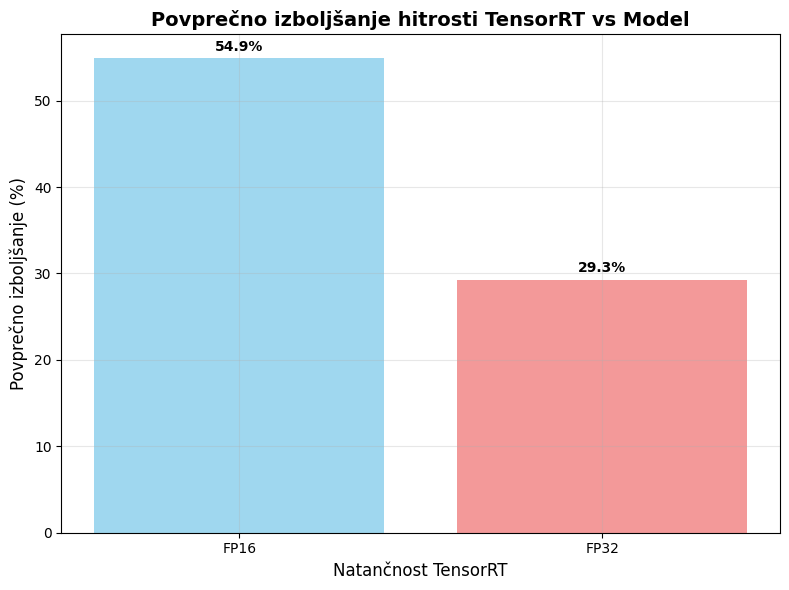

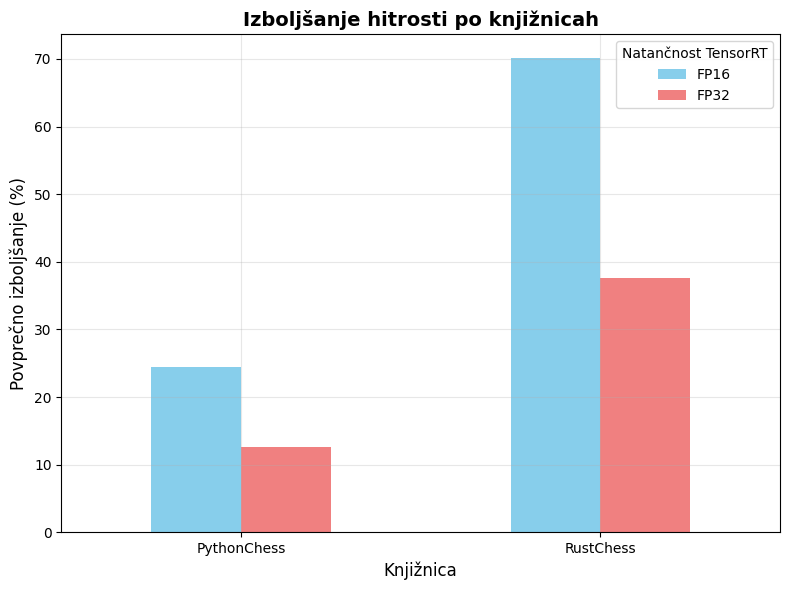

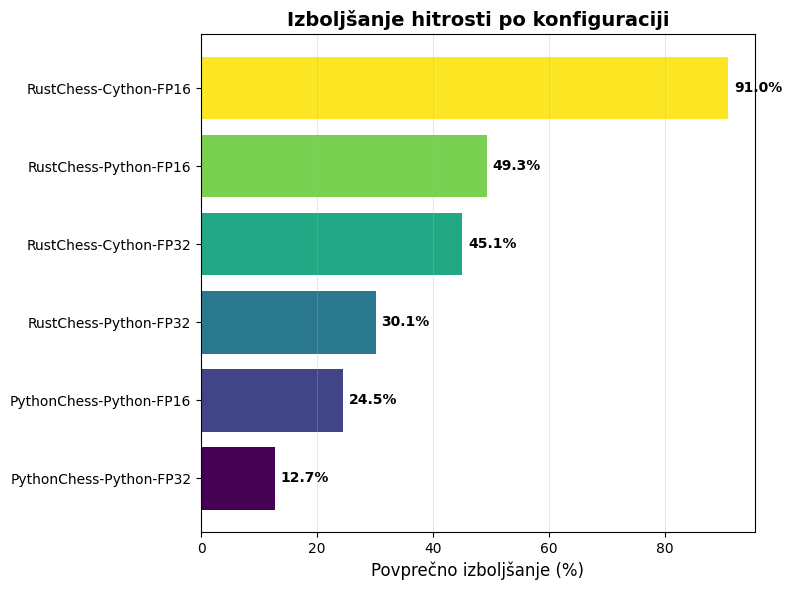

TENSORRT vs MODEL PERFORMANCE IMPROVEMENT ANALYSIS

📊 OVERALL STATISTICS:
Average TRT-FP32 improvement: 29.3%
Average TRT-FP16 improvement: 54.9%

🏆 BEST IMPROVEMENTS:
Best FP32: RustChess-Python @ 1 threads: 78.1%
Best FP16: RustChess-Cython @ 1 threads: 117.8%

📈 BY LIBRARY:
PythonChess: 18.6% average improvement
RustChess: 53.9% average improvement


In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# results are ("Library", "Language", "ModelType", "Precision", "NumParallelReads", "AvgNPS")

results_combined = [
    ('PythonChess', 'Python', 'Model', 'None', 1, 274.56),
    ('PythonChess', 'Python', 'Model', 'None', 16, 570.88),
    ('PythonChess', 'Python', 'Model', 'None', 32, 603.8399999999999),
    ('PythonChess', 'Python', 'TRT', 'FP32', 1, 370.15999999999997),
    ('PythonChess', 'Python', 'TRT', 'FP32', 16, 589.4399999999999),
    ('PythonChess', 'Python', 'TRT', 'FP32', 32, 603.5600000000001),
    ('PythonChess', 'Python', 'TRT', 'FP16', 1, 444.73999999999995),
    ('PythonChess', 'Python', 'TRT', 'FP16', 16, 617.9200000000001),
    ('PythonChess', 'Python', 'TRT', 'FP16', 32, 623.56),
    ('RustChess', 'Python', 'Model', 'None', 1, 385.3),
    ('RustChess', 'Python', 'Model', 'None', 16, 2398.7),
    ('RustChess', 'Python', 'Model', 'None', 32, 2926.31),
    ('RustChess', 'Cython', 'Model', 'None', 1, 474.10999999999996),
    ('RustChess', 'Cython', 'Model', 'None', 16, 5201.370000000001),
    ('RustChess', 'Cython', 'Model', 'None', 32, 7992.58),
    ('RustChess', 'Python', 'TRT', 'FP32', 1, 686.1),
    ('RustChess', 'Cython', 'TRT', 'FP32', 1, 816.1),
    ('RustChess', 'Python', 'TRT', 'FP16', 1, 835.0),
    ('RustChess', 'Cython', 'TRT', 'FP16', 1, 1032.7),
    ('RustChess', 'Python', 'TRT', 'FP32', 16, 2692.9),
    ('RustChess', 'Cython', 'TRT', 'FP32', 16, 7791.9),
    ('RustChess', 'Python', 'TRT', 'FP16', 16, 2913.8),
    ('RustChess', 'Cython', 'TRT', 'FP16', 16, 9414.3),
    ('RustChess', 'Python', 'TRT', 'FP32', 32, 2925.5),
    ('RustChess', 'Cython', 'TRT', 'FP32', 32, 9055.2),
    ('RustChess', 'Python', 'TRT', 'FP16', 32, 3211.5),
    ('RustChess', 'Cython', 'TRT', 'FP16', 32, 13914.4),
]

df = pd.DataFrame(results_combined, columns=[
    "Library", "Language", "ModelType", "Precision", "NumParallelReads", "AvgNPS"
])

# Create comparison between Model-None and TRT variants
model_data = df[df['ModelType'] == 'Model'].copy()
trt_data = df[df['ModelType'] == 'TRT'].copy()

# Calculate performance improvements
improvements = []
for _, model_row in model_data.iterrows():
    library = model_row['Library']
    language = model_row['Language']
    parallel_reads = model_row['NumParallelReads']
    model_nps = model_row['AvgNPS']
    
    # Find corresponding TRT FP32 performance
    trt_fp32 = trt_data[(trt_data['Library'] == library) & 
                        (trt_data['Language'] == language) & 
                        (trt_data['Precision'] == 'FP32') &
                        (trt_data['NumParallelReads'] == parallel_reads)]
    
    # Find corresponding TRT FP16 performance
    trt_fp16 = trt_data[(trt_data['Library'] == library) & 
                        (trt_data['Language'] == language) & 
                        (trt_data['Precision'] == 'FP16') &
                        (trt_data['NumParallelReads'] == parallel_reads)]
    
    if not trt_fp32.empty:
        fp32_improvement = (trt_fp32['AvgNPS'].iloc[0] / model_nps - 1) * 100
        improvements.append((library, language, parallel_reads, 'FP32', fp32_improvement))
    
    if not trt_fp16.empty:
        fp16_improvement = (trt_fp16['AvgNPS'].iloc[0] / model_nps - 1) * 100
        improvements.append((library, language, parallel_reads, 'FP16', fp16_improvement))

improvement_df = pd.DataFrame(improvements, columns=['Library', 'Language', 'ParallelReads', 'Precision', 'Improvement_%'])

# Create visualization
# Plot 1: Average improvement by precision
fig, ax1 = plt.subplots(figsize=(8, 6))
avg_improvements = improvement_df.groupby(['Precision'])['Improvement_%'].mean().reset_index()
bars = ax1.bar(avg_improvements['Precision'], avg_improvements['Improvement_%'], 
               color=['skyblue', 'lightcoral'], alpha=0.8)
ax1.set_title('Povprečno izboljšanje hitrosti TensorRT vs Model', fontsize=14, fontweight='bold')
ax1.set_xlabel('Natančnost TensorRT', fontsize=12)
ax1.set_ylabel('Povprečno izboljšanje (%)', fontsize=12)
ax1.grid(True, alpha=0.3)
for bar, val in zip(bars, avg_improvements['Improvement_%']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# Plot 2: Improvement by library and precision
fig, ax2 = plt.subplots(figsize=(8, 6))
improvement_pivot = improvement_df.pivot_table(index='Library', columns='Precision', values='Improvement_%', aggfunc='mean')
improvement_pivot.plot(kind='bar', ax=ax2, color=['skyblue', 'lightcoral'])
ax2.set_title('Izboljšanje hitrosti po knjižnicah', fontsize=14, fontweight='bold')
ax2.set_xlabel('Knjižnica', fontsize=12)
ax2.set_ylabel('Povprečno izboljšanje (%)', fontsize=12)
ax2.legend(title='Natančnost TensorRT')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

# Plot 4: Detailed comparison by configuration
fig, ax4 = plt.subplots(figsize=(8, 6))
improvement_df['Config'] = improvement_df['Library'] + '-' + improvement_df['Language'] + '-' + improvement_df['Precision']
config_avg = improvement_df.groupby('Config')['Improvement_%'].mean().sort_values(ascending=True)
bars = ax4.barh(range(len(config_avg)), config_avg.values, 
                color=plt.cm.viridis(np.linspace(0, 1, len(config_avg))))
ax4.set_yticks(range(len(config_avg)))
ax4.set_yticklabels(config_avg.index, fontsize=10)
ax4.set_title('Izboljšanje hitrosti po konfiguraciji', fontsize=14, fontweight='bold')
ax4.set_xlabel('Povprečno izboljšanje (%)', fontsize=12)
ax4.grid(True, alpha=0.3, axis='x')

for i, val in enumerate(config_avg.values):
    ax4.text(val + 1, i, f'{val:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*80)
print("TENSORRT vs MODEL PERFORMANCE IMPROVEMENT ANALYSIS")
print("="*80)

print(f"\n📊 OVERALL STATISTICS:")
print(f"Average TRT-FP32 improvement: {improvement_df[improvement_df['Precision'] == 'FP32']['Improvement_%'].mean():.1f}%")
print(f"Average TRT-FP16 improvement: {improvement_df[improvement_df['Precision'] == 'FP16']['Improvement_%'].mean():.1f}%")

print(f"\n🏆 BEST IMPROVEMENTS:")
best_fp32 = improvement_df[improvement_df['Precision'] == 'FP32'].loc[improvement_df[improvement_df['Precision'] == 'FP32']['Improvement_%'].idxmax()]
best_fp16 = improvement_df[improvement_df['Precision'] == 'FP16'].loc[improvement_df[improvement_df['Precision'] == 'FP16']['Improvement_%'].idxmax()]

print(f"Best FP32: {best_fp32['Library']}-{best_fp32['Language']} @ {best_fp32['ParallelReads']} threads: {best_fp32['Improvement_%']:.1f}%")
print(f"Best FP16: {best_fp16['Library']}-{best_fp16['Language']} @ {best_fp16['ParallelReads']} threads: {best_fp16['Improvement_%']:.1f}%")

print(f"\n📈 BY LIBRARY:")
for library in improvement_df['Library'].unique():
    lib_data = improvement_df[improvement_df['Library'] == library]
    avg_improvement = lib_data['Improvement_%'].mean()
    print(f"{library}: {avg_improvement:.1f}% average improvement")


In [20]:
df

,Library,Language,ModelType,Precision,NumParallelReads,AvgNPS
0,PythonChess,Python,Model,None,1,274.56
1,PythonChess,Python,Model,None,16,570.88
2,PythonChess,Python,Model,None,32,603.84
3,PythonChess,Python,TRT,FP32,1,370.16
4,PythonChess,Python,TRT,FP32,16,589.44
5,PythonChess,Python,TRT,FP32,32,603.56
6,PythonChess,Python,TRT,FP16,1,444.74
7,PythonChess,Python,TRT,FP16,16,617.92
8,PythonChess,Python,TRT,FP16,32,623.56
9,RustChess,Python,Model,None,1,385.30


In [32]:
perft_results = [{'Position': 'Initial',
  'Depth': 3,
  'Library': 'python-chess',
  'Avg Time (s)': 0.07952327728271484,
  'Nodes': 8902},
 {'Position': 'Initial',
  'Depth': 3,
  'Library': 'rchess',
  'Avg Time (s)': 0.004886007308959961,
  'Nodes': 8902},
 {'Position': 'Initial',
  'Depth': 4,
  'Library': 'python-chess',
  'Avg Time (s)': 1.5494667530059814,
  'Nodes': 197281},
 {'Position': 'Initial',
  'Depth': 4,
  'Library': 'rchess',
  'Avg Time (s)': 0.10483388900756836,
  'Nodes': 197281},
 {'Position': 'KiwiPete (Pos 2)',
  'Depth': 3,
  'Library': 'python-chess',
  'Avg Time (s)': 0.7435322761535644,
  'Nodes': 97862},
 {'Position': 'KiwiPete (Pos 2)',
  'Depth': 3,
  'Library': 'rchess',
  'Avg Time (s)': 0.04950494766235351,
  'Nodes': 97862},
 {'Position': 'KiwiPete (Pos 2)',
  'Depth': 4,
  'Library': 'python-chess',
  'Avg Time (s)': 31.774331951141356,
  'Nodes': 4085603},
 {'Position': 'KiwiPete (Pos 2)',
  'Depth': 4,
  'Library': 'rchess',
  'Avg Time (s)': 2.084269094467163,
  'Nodes': 4085603},
 {'Position': 'Pos 3',
  'Depth': 3,
  'Library': 'python-chess',
  'Avg Time (s)': 0.023418188095092773,
  'Nodes': 2812},
 {'Position': 'Pos 3',
  'Depth': 3,
  'Library': 'rchess',
  'Avg Time (s)': 0.0015196800231933594,
  'Nodes': 2812},
 {'Position': 'Pos 3',
  'Depth': 4,
  'Library': 'python-chess',
  'Avg Time (s)': 0.3737182140350342,
  'Nodes': 43238},
 {'Position': 'Pos 3',
  'Depth': 4,
  'Library': 'rchess',
  'Avg Time (s)': 0.023618364334106447,
  'Nodes': 43238}]

df_perft = pd.DataFrame(perft_results)

# Convert time to milliseconds for better readability also round to 2 decimal places
df_perft['Avg Time (ms)'] = (df_perft['Avg Time (s)'] * 1000).round(1)

# Create a pivot table for better visualization
pivot_perft = df_perft.pivot_table(
    index=['Position', 'Depth'],
    columns='Library',
    values='Avg Time (ms)',
    aggfunc='mean'
).reset_index()
pivot_perft

Library,Position,Depth,python-chess,rchess
0,Initial,3,79.5,4.9
1,Initial,4,1549.5,104.8
2,KiwiPete (Pos 2),3,743.5,49.5
3,KiwiPete (Pos 2),4,31774.3,2084.3
4,Pos 3,3,23.4,1.5
5,Pos 3,4,373.7,23.6


In [28]:
df_perft

,Position,Depth,Library,Avg Time (s),Nodes,Avg Time (ms)
0,Initial,3,python-chess,0.079523,8902,79.52
1,Initial,3,rchess,0.004886,8902,4.89
2,Initial,4,python-chess,1.549467,197281,1549.47
3,Initial,4,rchess,0.104834,197281,104.83
4,KiwiPete (Pos 2),3,python-chess,0.743532,97862,743.53
5,KiwiPete (Pos 2),3,rchess,0.049505,97862,49.50
6,KiwiPete (Pos 2),4,python-chess,31.774332,4085603,31774.33
7,KiwiPete (Pos 2),4,rchess,2.084269,4085603,2084.27
8,Pos 3,3,python-chess,0.023418,2812,23.42
9,Pos 3,3,rchess,0.001520,2812,1.52
